### HOMEWORK-1 

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import random, copy
from pandas import DataFrame


In [24]:
# Enable the experimental feature
from sklearn.experimental import enable_iterative_imputer
# Now you can import IterativeImputer
from sklearn.impute import IterativeImputer


In [25]:
import pandas as pd
import numpy as np
import random
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, accuracy_score

In [42]:
#This function add random NaN values to df

def introduce_nans(df: pd.DataFrame,
                   row_ratio: float,
                   ratio: float,
                   border: float = None):

    if border is None:
        border = 0
    for index, row in df.iterrows():
        if random.random() < row_ratio:
            no_of_nans = int((border + ratio) * df.shape[1])
            nan_locs = random.sample(range(0, df.shape[1]), no_of_nans)
            for nan_loc in nan_locs:
                df.at[index, df.columns[nan_loc]] = np.nan
    return df

In [47]:
# Understanding the nature of data 

In [48]:
file_path = 'ObesityDataSet_raw_and_data_sinthetic.csv'
df = pd.read_csv(file_path)
df_missing= df.copy()

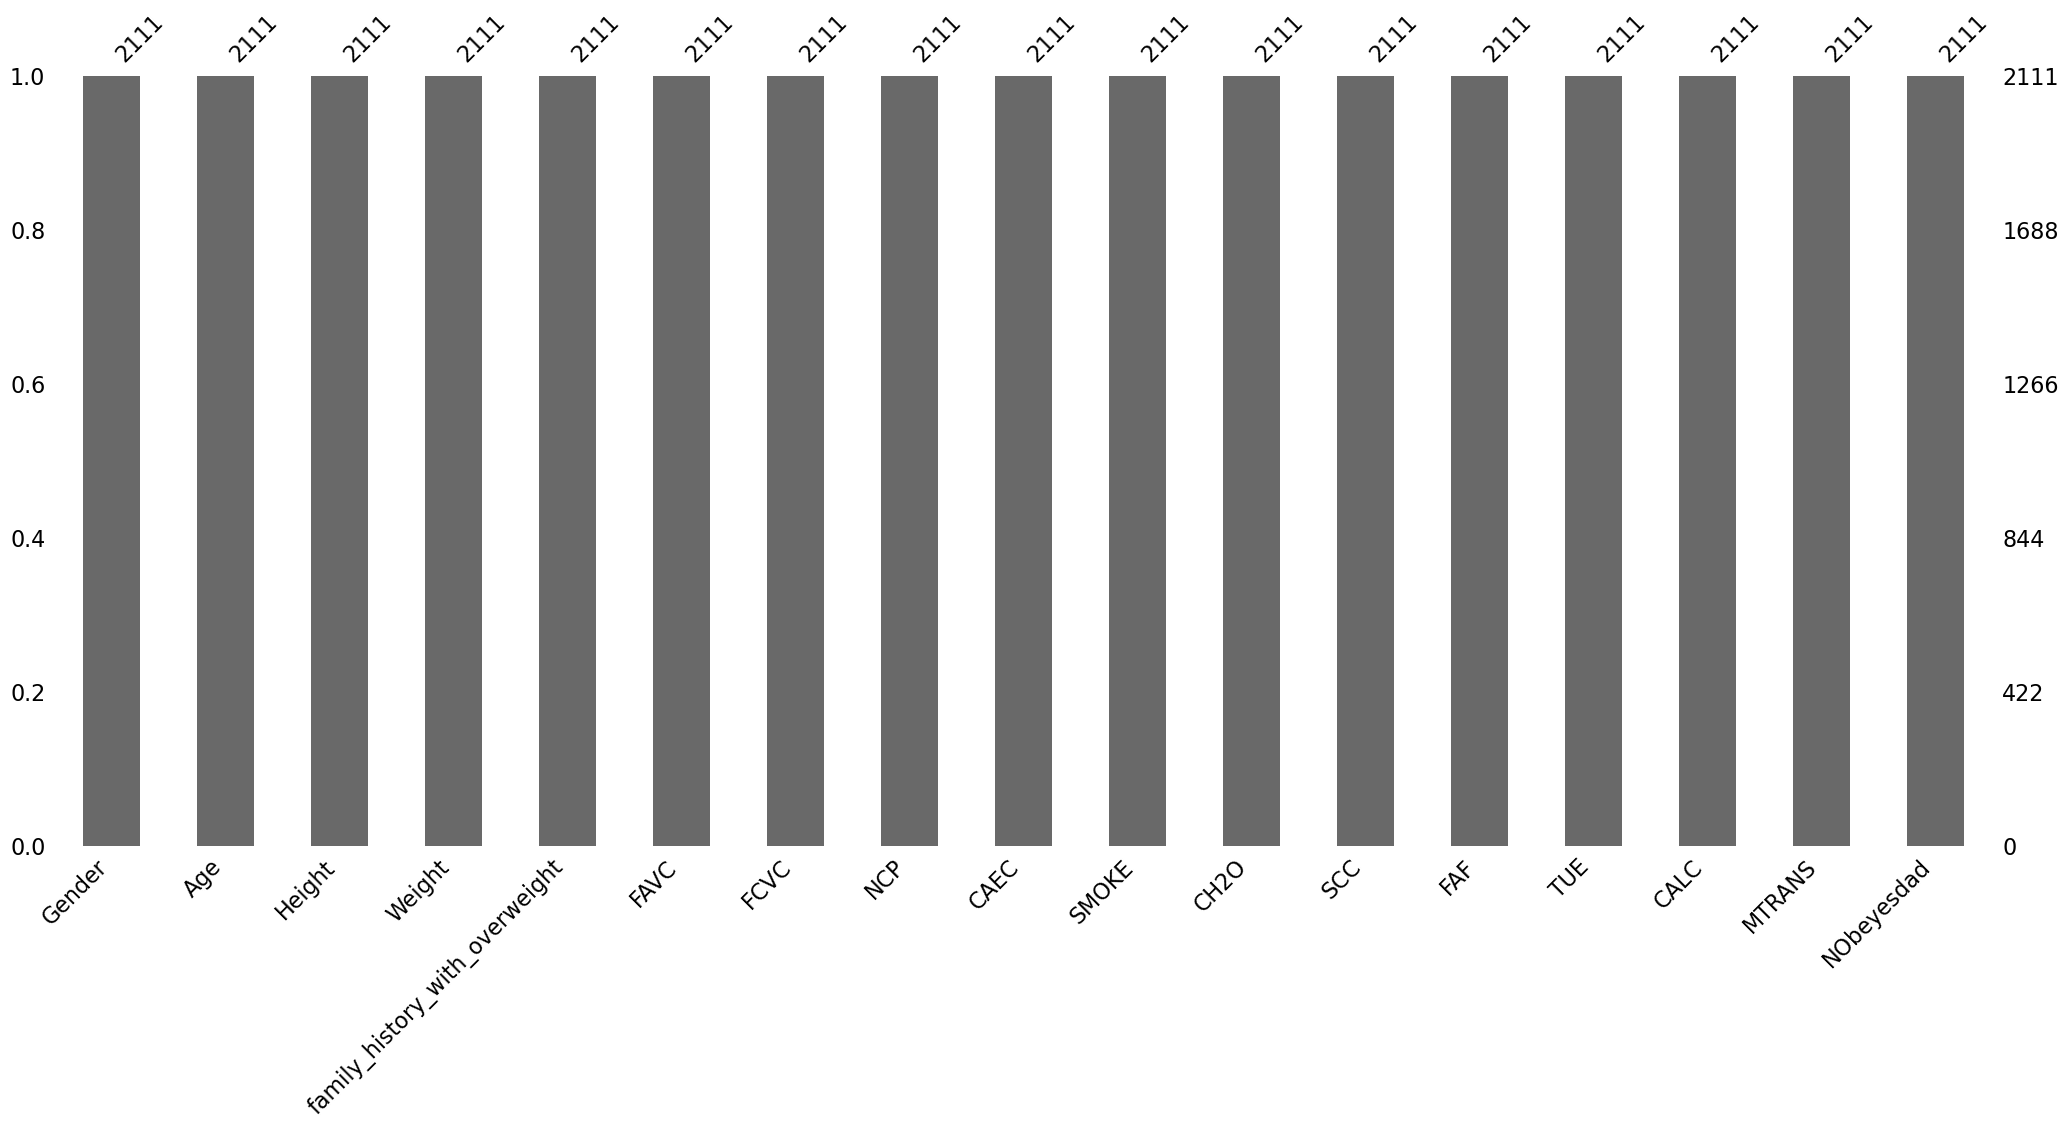

In [49]:
msno.bar(df)
plt.show()

#### There are no null values in orginal version of data 

In [50]:
nanned_df = introduce_nans(df=df_missing, row_ratio=0.25, ratio=0.5)

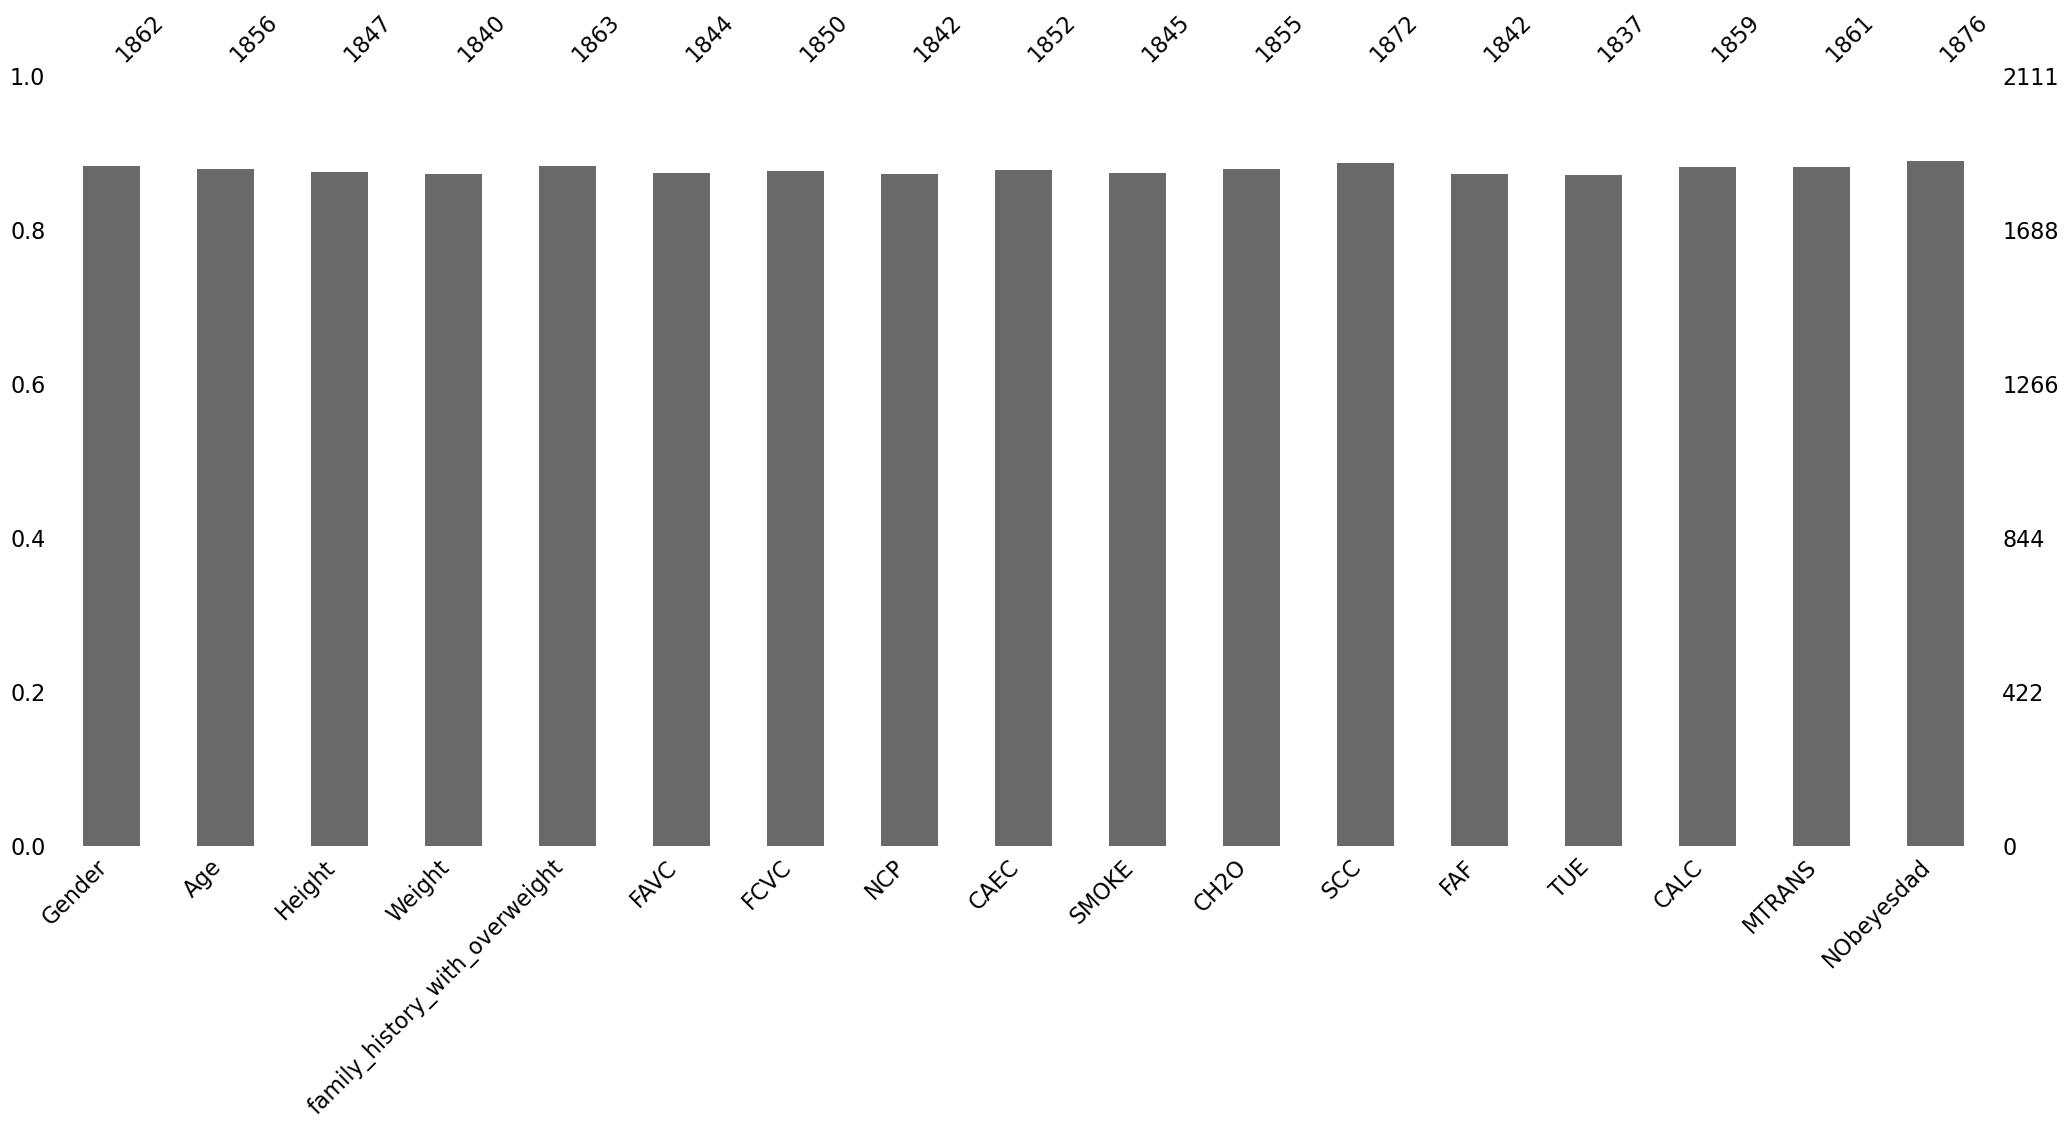

In [51]:
msno.bar(nanned_df)
plt.show()

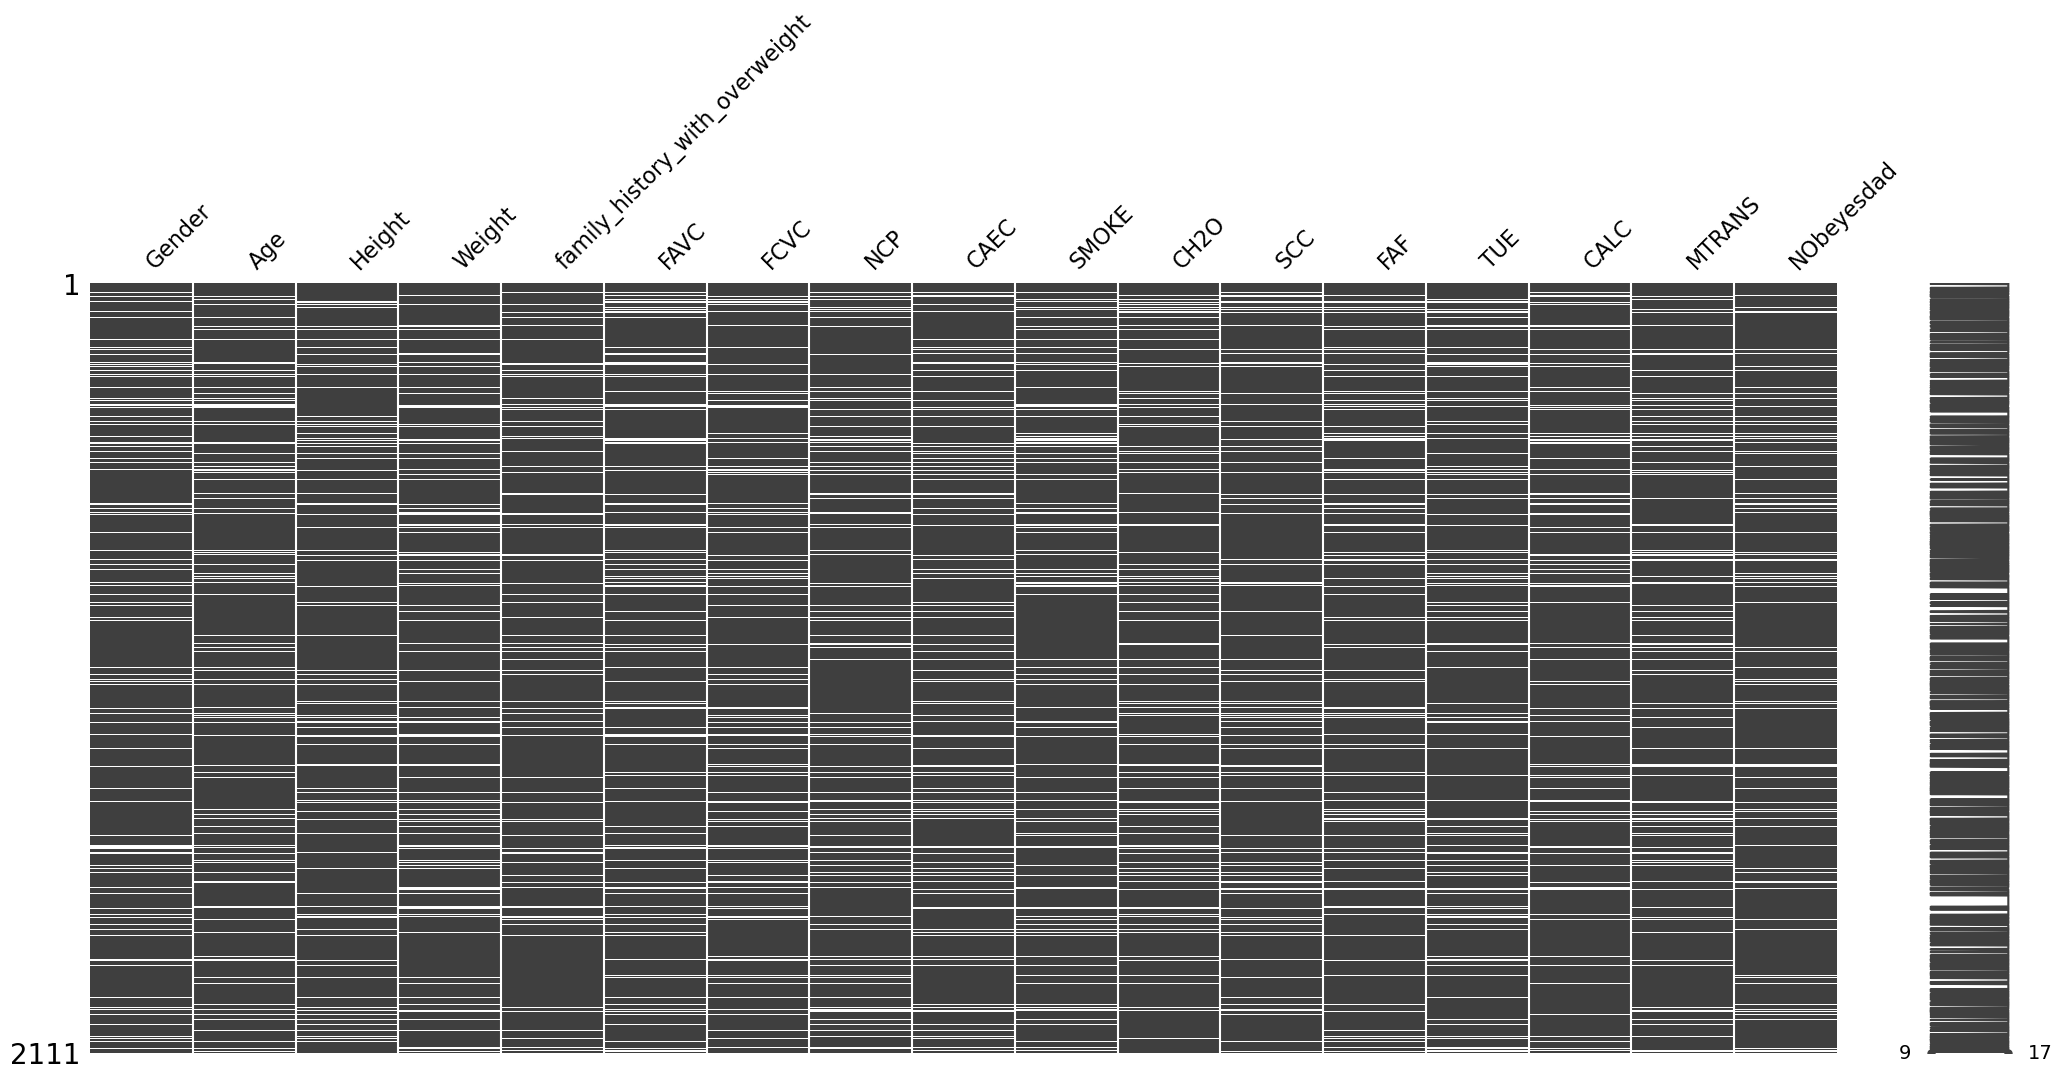

In [53]:
msno.matrix(nanned_df)
plt.show()

In [54]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [55]:
missing_values_table(nanned_df, True)
na_cols = missing_values_table(nanned_df, True)

                                n_miss  ratio
TUE                                274  12.98
Weight                             271  12.84
NCP                                269  12.74
FAF                                269  12.74
FAVC                               267  12.65
SMOKE                              266  12.60
Height                             264  12.51
FCVC                               261  12.36
CAEC                               259  12.27
CH2O                               256  12.13
Age                                255  12.08
CALC                               252  11.94
MTRANS                             250  11.84
Gender                             249  11.80
family_history_with_overweight     248  11.75
SCC                                239  11.32
NObeyesdad                         235  11.13
                                n_miss  ratio
TUE                                274  12.98
Weight                             271  12.84
NCP                               

In [56]:
# Mean values gives insight about behavior of missing values.

In [57]:
nanned_df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,1856.000000,1847.000000,1840.000000,1850.000000,1842.000000,1855.000000,1842.000000,1837.000000
mean,24.360281,1.702801,86.632895,2.425082,2.681182,2.005431,1.004191,0.659737
std,6.349903,0.093825,26.268447,0.533107,0.777082,0.609763,0.854906,0.609631
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.998636,1.630000,65.346250,2.000000,2.655596,1.575789,0.115520,0.000000
50%,22.834210,1.701397,82.977398,2.397282,3.000000,2.000000,1.000000,0.630866
75%,26.000000,1.770000,108.025486,3.000000,3.000000,2.472312,1.655867,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [58]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [59]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [64]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df1)

Observations: 2111
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 0


In [ ]:
print("Categorical Columns:", cat_cols, "Numerical Columns:", num_cols, "Seems like a Categoric but numeric:", cat_but_car, sep= "\n")

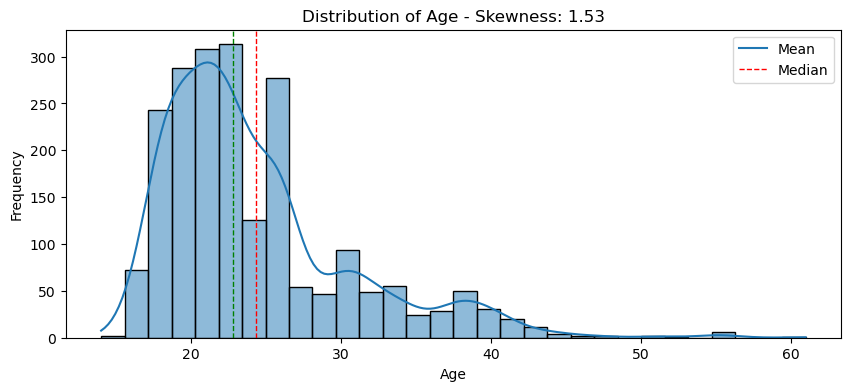

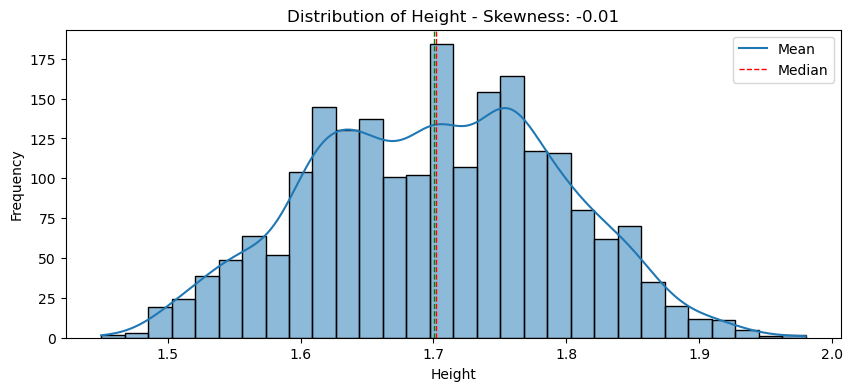

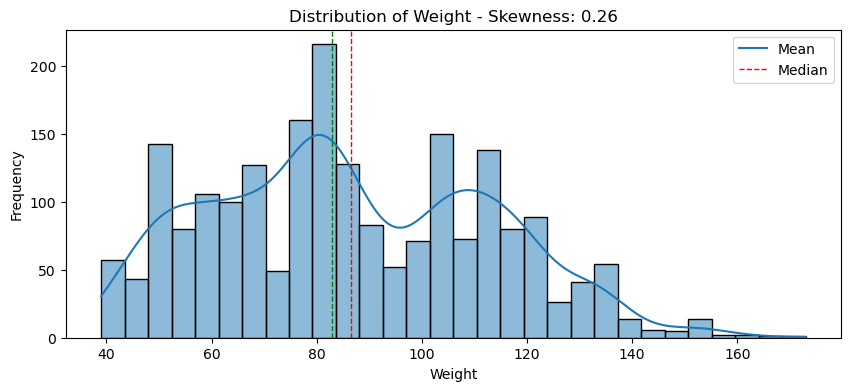

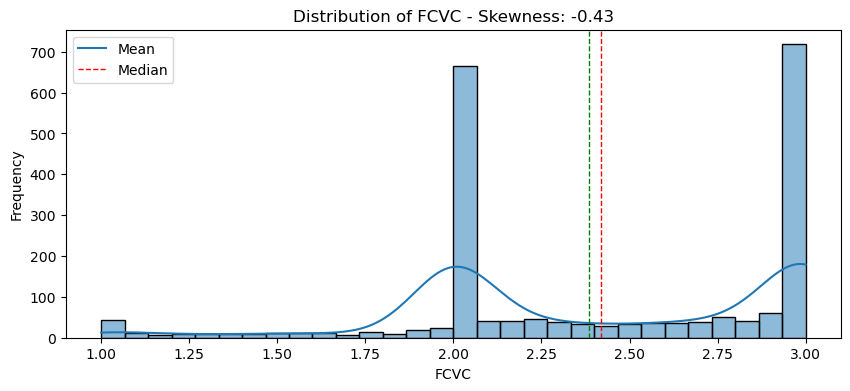

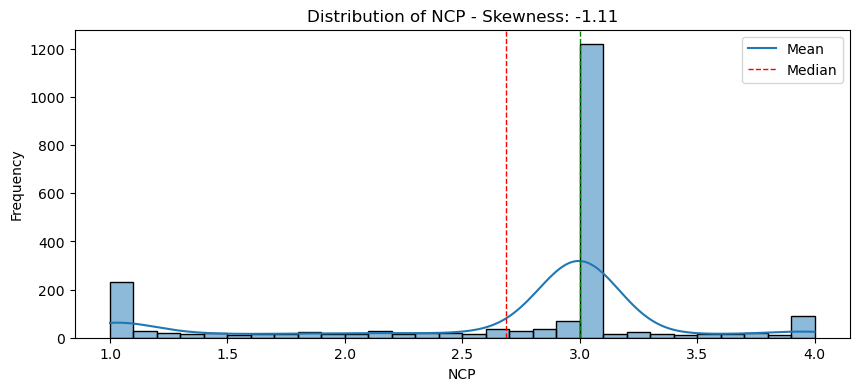

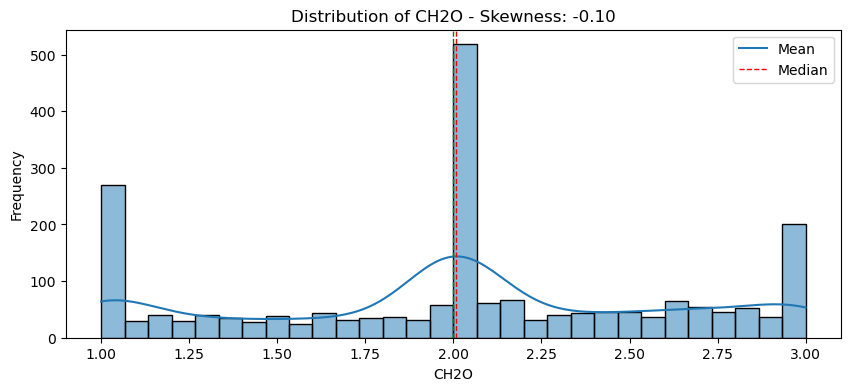

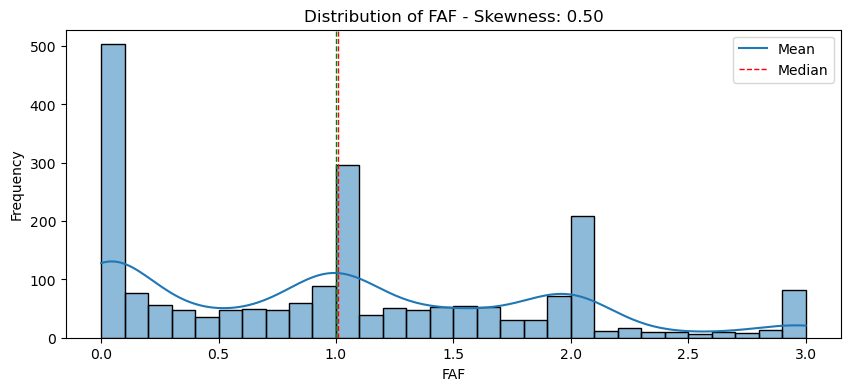

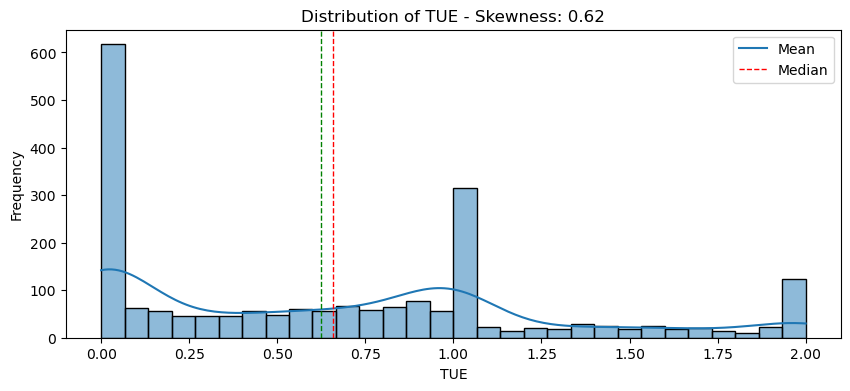

Skewness Values:
Age: 1.53 (right skewed)
Height: -0.01 (approximately symmetric)
Weight: 0.26 (approximately symmetric)
FCVC: -0.43 (approximately symmetric)
NCP: -1.11 (left skewed)
CH2O: -0.10 (approximately symmetric)
FAF: 0.50 (approximately symmetric)
TUE: 0.62 (right skewed)


In [62]:
## Original data 
numeric_cols = num_cols
from scipy.stats import skew

# Skewness hesaplama ve görselleştirme
skew_values = {}
for col in numeric_cols:
    skew_values[col] = skew(df1[col].dropna())
    plt.figure(figsize=(10, 4))
    sns.histplot(df1[col], kde=True, bins=30)
    plt.title(f'Distribution of {col} - Skewness: {skew_values[col]:.2f}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.axvline(df1[col].mean(), color='r', linestyle='dashed', linewidth=1)
    plt.axvline(df1[col].median(), color='g', linestyle='dashed', linewidth=1)
    plt.legend({'Mean':df[col].mean(),'Median':df1[col].median()})
    plt.show()

# Skewness değerlerini yazdırma
print("Skewness Values:")
for col, skew_val in skew_values.items():
    print(f"{col}: {skew_val:.2f} {'(left skewed)' if skew_val < -0.5 else '(right skewed)' if skew_val > 0.5 else '(approximately symmetric)'}")


In [63]:
## Data with missing values 

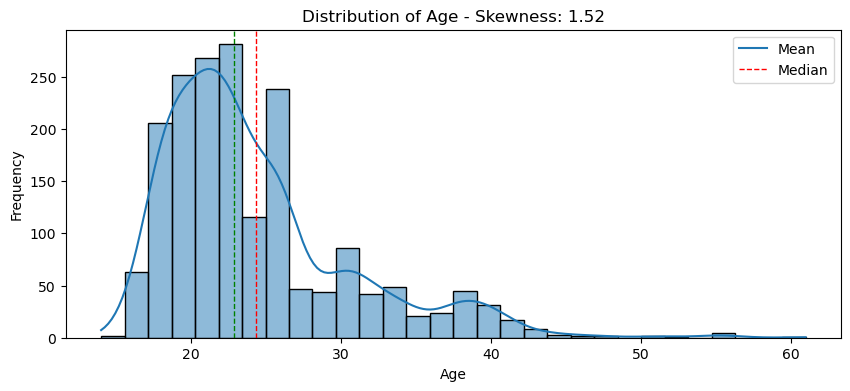

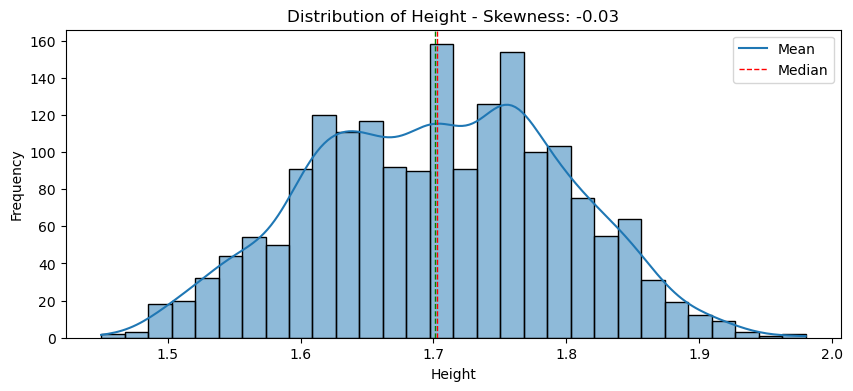

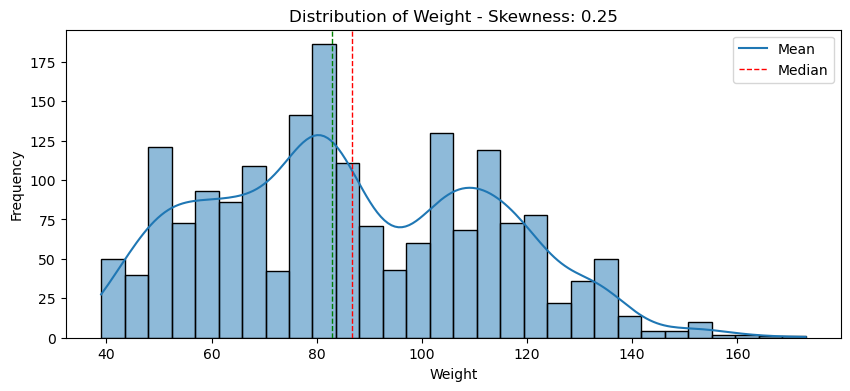

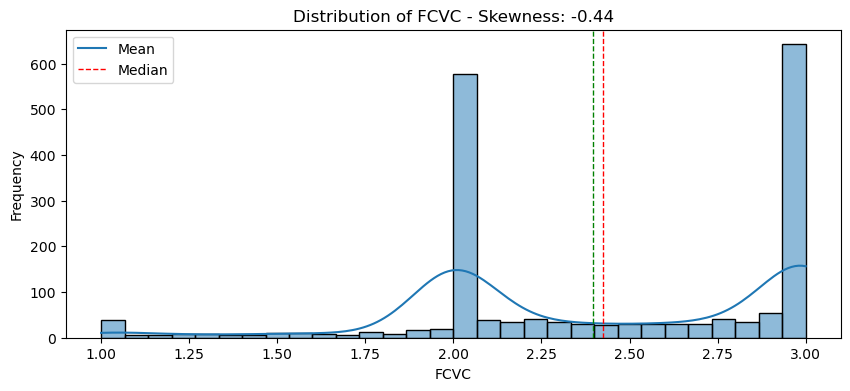

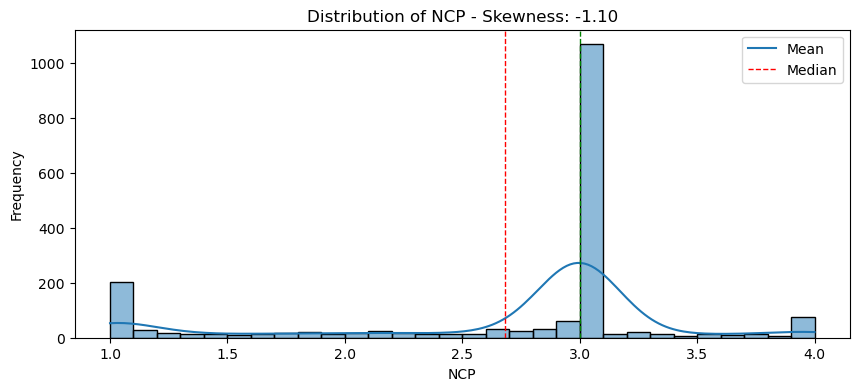

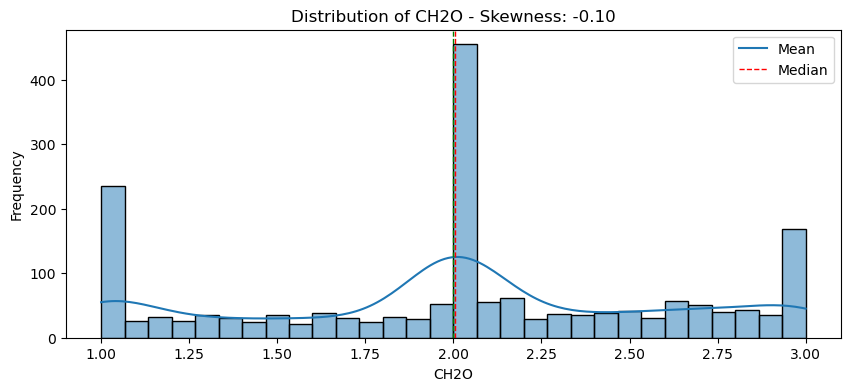

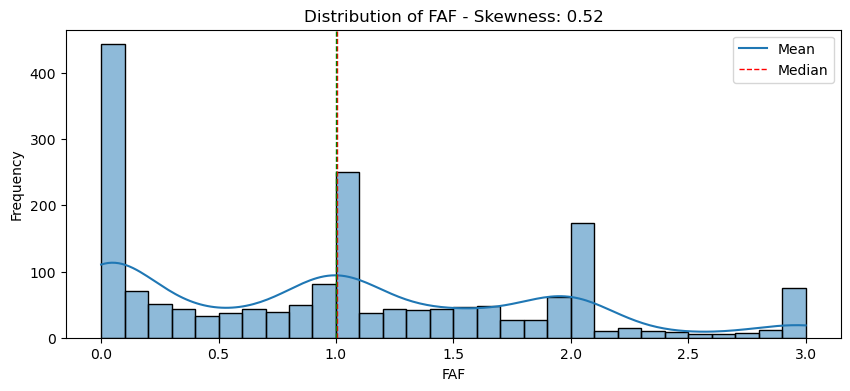

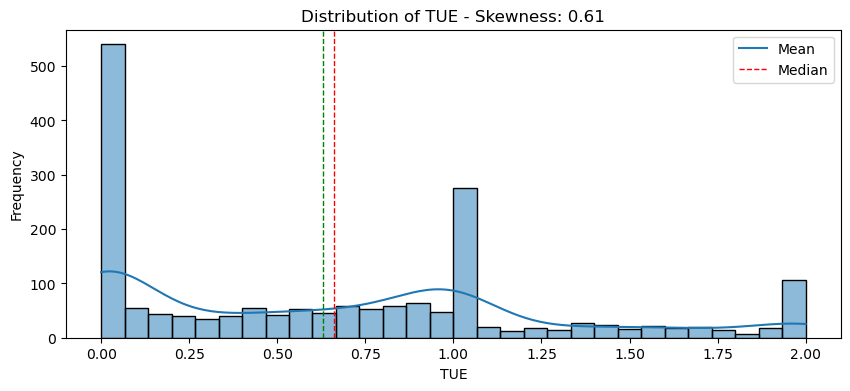

Skewness Values:
Age: 1.52 (right skewed)
Height: -0.03 (approximately symmetric)
Weight: 0.25 (approximately symmetric)
FCVC: -0.44 (approximately symmetric)
NCP: -1.10 (left skewed)
CH2O: -0.10 (approximately symmetric)
FAF: 0.52 (right skewed)
TUE: 0.61 (right skewed)


In [65]:
## Original data 
numeric_cols = num_cols
from scipy.stats import skew

# Skewness hesaplama ve görselleştirme
skew_values = {}
for col in numeric_cols:
    skew_values[col] = skew(nanned_df[col].dropna())
    plt.figure(figsize=(10, 4))
    sns.histplot(nanned_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col} - Skewness: {skew_values[col]:.2f}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.axvline(nanned_df[col].mean(), color='r', linestyle='dashed', linewidth=1)
    plt.axvline(nanned_df[col].median(), color='g', linestyle='dashed', linewidth=1)
    plt.legend({'Mean':nanned_df[col].mean(),'Median':nanned_df[col].median()})
    plt.show()

# Skewness değerlerini yazdırma
print("Skewness Values:")
for col, skew_val in skew_values.items():
    print(f"{col}: {skew_val:.2f} {'(left skewed)' if skew_val < -0.5 else '(right skewed)' if skew_val > 0.5 else '(approximately symmetric)'}")


In [67]:
# Skewness değerlerini yanyana yazdırma
print("Skewness Values Comparison:")
print(f"{'Column':<15} {'Original Data':<20} {'Nanned Data':<20}")
for col in numeric_cols:
    skew_df1 = skew_values_df1.get(col, 'N/A')
    skew_nanned = skew_values_nanned_df.get(col, 'N/A')
    skew_df1_label = f"{skew_df1:.2f} {'(left skewed)' if skew_df1 < -0.5 else '(right skewed)' if skew_df1 > 0.5 else '(approximately symmetric)'}"
    skew_nanned_label = f"{skew_nanned:.2f} {'(left skewed)' if skew_nanned < -0.5 else '(right skewed)' if skew_nanned > 0.5 else '(approximately symmetric)'}"
    print(f"{col:<15} {skew_df1_label:<20} {skew_nanned_label:<20}")


Skewness Values Comparison:
Column          Original Data        Nanned Data         
Age             1.53 (right skewed)  1.52 (right skewed) 
Height          -0.01 (approximately symmetric) -0.03 (approximately symmetric)
Weight          0.26 (approximately symmetric) 0.25 (approximately symmetric)
FCVC            -0.43 (approximately symmetric) -0.44 (approximately symmetric)
NCP             -1.11 (left skewed)  -1.10 (left skewed) 
CH2O            -0.10 (approximately symmetric) -0.10 (approximately symmetric)
FAF             0.50 (approximately symmetric) 0.52 (right skewed) 
TUE             0.62 (right skewed)  0.61 (right skewed) 


### 10-10 Veri Eksiltme

In [4]:
# Path to the CSV file
file_path = 'ObesityDataSet_raw_and_data_sinthetic.csv'

# Reading the CSV file
df1 = pd.read_csv(file_path)
df_original=df1.copy()
df_missing = introduce_nans(df=df1, row_ratio=0.10, ratio=0.10)

In [5]:
#Label Encoding 
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Textual özellikler
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Kategorik özellikler için LabelEncoder
label_encoders = {}

# df_missing üzerinde encode işlemi yapın
for column in textual_features:
    le = LabelEncoder()
    df_missing[column] = le.fit_transform(df_missing[column].astype(str))
    label_encoders[column] = le

# df_original üzerinde encode işlemi yapın
for column in textual_features:
    le = label_encoders[column]
    df_original[column] = le.transform(df_original[column].astype(str))



In [6]:
df_original.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,2,1,2.0,3.0,2,1,2.0,1,0.0,1.0,4,3,1
1,0,21.0,1.52,56.0,2,1,3.0,3.0,2,2,3.0,2,3.0,0.0,2,3,1
2,1,23.0,1.80,77.0,2,1,2.0,3.0,2,1,2.0,1,2.0,1.0,1,3,1
3,1,27.0,1.80,87.0,1,1,3.0,3.0,2,1,2.0,1,2.0,0.0,1,4,5
4,1,22.0,1.78,89.8,1,1,2.0,1.0,2,1,2.0,1,0.0,0.0,2,3,6


In [7]:
df_missing.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,2,1,2.0,3.0,2,1,2.0,1,0.0,1.0,4,3,1
1,0,21.0,1.52,56.0,2,1,3.0,3.0,2,2,3.0,2,3.0,0.0,2,3,1
2,1,23.0,1.80,77.0,2,1,2.0,3.0,2,1,2.0,1,2.0,1.0,1,3,1
3,1,27.0,1.80,87.0,1,1,3.0,3.0,2,1,2.0,1,2.0,0.0,1,4,5
4,1,22.0,1.78,89.8,1,1,2.0,1.0,2,1,2.0,1,0.0,0.0,2,3,6


In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, accuracy_score

# Numeric and Textual Features
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Parametre kombinasyonları
iterative_params = [
    {'estimator': RandomForestRegressor(), 'max_iter': 2, 'random_state': 42},
    {'estimator': CatBoostRegressor(silent=True), 'max_iter': 2, 'random_state': 42},
]

knn_params = [
    {'n_neighbors': 30},
    {'n_neighbors': 45},
]

# Eksik veri doldurma yöntemleri için imputers tanımlayın
numeric_imputers = {
    'SimpleImputer (mean)': SimpleImputer(strategy='mean'),
    'SimpleImputer (median)': SimpleImputer(strategy='median'),
    'SimpleImputer (most_frequent)': SimpleImputer(strategy='most_frequent')
}

# IterativeImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(iterative_params):
    numeric_imputers[f'IterativeImputer {i+1}'] = IterativeImputer(**params)

# KNNImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(knn_params):
    numeric_imputers[f'KNNImputer {i+1}'] = KNNImputer(**params)

# Categorical imputerlar
categorical_imputers = {
    'KNNImputer': KNNImputer(n_neighbors=5)
}

results_numeric = {}
results_categorical = {}

# Numeric features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in numeric_imputers.items():
    X_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_missing[numeric_features]), columns=numeric_features)
    # NaN değerleri kontrol et ve gerekirse doldur
    if X_numeric_imputed.isnull().values.any():
        X_numeric_imputed = X_numeric_imputed.fillna(0)

    r2_scores = {col: r2_score(df_original[col], X_numeric_imputed[col]) for col in numeric_features}
    results_numeric[name] = r2_scores

# Textual features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in categorical_imputers.items():
    X_textual_imputed = pd.DataFrame(imputer.fit_transform(df_missing[textual_features]), columns=textual_features)
    accuracy_scores = {col: accuracy_score(df_original[col], X_textual_imputed[col]) for col in textual_features}
    results_categorical[name] = accuracy_scores

# Sonuçları yazdırın
print("R2 Scores for Each Imputation Method (Numeric Features):")
for method, scores in results_numeric.items():
    print(f"\nMethod: {method}")
    total_score = 0
    for column, score in scores.items():
        print(f"Column: {column}, R2 Score: {score:.4f}")
        total_score += score
    average_score = total_score / len(scores)
    print(f"Average R2 Score for {method}: {average_score:.4f}")

print("\nAccuracy Scores for Each Imputation Method on Textual Features:")
for method, scores in results_categorical.items():
    print(f"\nMethod: {method}")
    total_accuracy = 0
    for column, score in scores.items():
        print(f"Column: {column}, Accuracy Score: {score:.5%}")
        total_accuracy += score
    average_accuracy = total_accuracy / len(scores)
    print(f"Average Accuracy Score for {method}: {average_accuracy:.5%}")

# En iyi yöntemi belirleyin
best_method_numeric = max(results_numeric, key=lambda method: np.mean(list(results_numeric[method].values())))
best_numeric_avg_score = np.mean(list(results_numeric[best_method_numeric].values()))
print(f"\nBest Imputation Method for Numeric Features: {best_method_numeric} with Average R2 Score: {best_numeric_avg_score:.3f}")

best_method_categorical = max(results_categorical, key=lambda method: np.mean(list(results_categorical[method].values())))
best_categorical_avg_score = np.mean(list(results_categorical[best_method_categorical].values()))
print(f"\nBest Imputation Method for Categorical Features: {best_method_categorical} with Average Accuracy Score: {best_categorical_avg_score:.3%}")


# En iyi imputer ile eksik veriyi doldurun ve çıktısını verin
best_imputer = categorical_imputers[best_method_categorical]
df_best_imputed = pd.DataFrame(best_imputer.fit_transform(df_missing[textual_features]), columns=textual_features)



C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


R2 Scores for Each Imputation Method (Numeric Features):

Method: SimpleImputer (mean)
Column: Age, R2 Score: 0.9924
Column: Height, R2 Score: 0.9946
Column: Weight, R2 Score: 0.9935
Column: FCVC, R2 Score: 0.9910
Column: NCP, R2 Score: 0.9913
Column: CH2O, R2 Score: 0.9916
Column: FAF, R2 Score: 0.9935
Column: TUE, R2 Score: 0.9961
Average R2 Score for SimpleImputer (mean): 0.9930

Method: SimpleImputer (median)
Column: Age, R2 Score: 0.9917
Column: Height, R2 Score: 0.9946
Column: Weight, R2 Score: 0.9934
Column: FCVC, R2 Score: 0.9905
Column: NCP, R2 Score: 0.9896
Column: CH2O, R2 Score: 0.9915
Column: FAF, R2 Score: 0.9936
Column: TUE, R2 Score: 0.9962
Average R2 Score for SimpleImputer (median): 0.9927

Method: SimpleImputer (most_frequent)
Column: Age, R2 Score: 0.9849
Column: Height, R2 Score: 0.9946
Column: Weight, R2 Score: 0.9931
Column: FCVC, R2 Score: 0.9868
Column: NCP, R2 Score: 0.9896
Column: CH2O, R2 Score: 0.9915
Column: FAF, R2 Score: 0.9898
Column: TUE, R2 Score: 0.9

C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 25-25 Veri Eksiltme

In [12]:
# Path to the CSV file
file_path = 'ObesityDataSet_raw_and_data_sinthetic.csv'

# Reading the CSV file
df1 = pd.read_csv(file_path)
df_original=df1.copy()
df_missing = introduce_nans(df=df1, row_ratio=0.25, ratio=0.25)

In [13]:
#Label Encoding 
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Textual özellikler
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Kategorik özellikler için LabelEncoder
label_encoders = {}

# df_missing üzerinde encode işlemi yapın
for column in textual_features:
    le = LabelEncoder()
    df_missing[column] = le.fit_transform(df_missing[column].astype(str))
    label_encoders[column] = le

# df_original üzerinde encode işlemi yapın
for column in textual_features:
    le = label_encoders[column]
    df_original[column] = le.transform(df_original[column].astype(str))



In [14]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, accuracy_score

# Numeric and Textual Features
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Parametre kombinasyonları
iterative_params = [
    {'estimator': RandomForestRegressor(), 'max_iter': 2, 'random_state': 42},
    {'estimator': CatBoostRegressor(silent=True), 'max_iter': 2, 'random_state': 42},
]

knn_params = [
    {'n_neighbors': 30},
    {'n_neighbors': 45},
]

# Eksik veri doldurma yöntemleri için imputers tanımlayın
numeric_imputers = {
    'SimpleImputer (mean)': SimpleImputer(strategy='mean'),
    'SimpleImputer (median)': SimpleImputer(strategy='median'),
    'SimpleImputer (most_frequent)': SimpleImputer(strategy='most_frequent')
}

# IterativeImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(iterative_params):
    numeric_imputers[f'IterativeImputer {i+1}'] = IterativeImputer(**params)

# KNNImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(knn_params):
    numeric_imputers[f'KNNImputer {i+1}'] = KNNImputer(**params)

# Categorical imputerlar
categorical_imputers = {
    'KNNImputer': KNNImputer(n_neighbors=5)
}

results_numeric = {}
results_categorical = {}

# Numeric features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in numeric_imputers.items():
    X_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_missing[numeric_features]), columns=numeric_features)
    # NaN değerleri kontrol et ve gerekirse doldur
    if X_numeric_imputed.isnull().values.any():
        X_numeric_imputed = X_numeric_imputed.fillna(0)

    r2_scores = {col: r2_score(df_original[col], X_numeric_imputed[col]) for col in numeric_features}
    results_numeric[name] = r2_scores

# Textual features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in categorical_imputers.items():
    X_textual_imputed = pd.DataFrame(imputer.fit_transform(df_missing[textual_features]), columns=textual_features)
    accuracy_scores = {col: accuracy_score(df_original[col], X_textual_imputed[col]) for col in textual_features}
    results_categorical[name] = accuracy_scores

# Sonuçları yazdırın
print("R2 Scores for Each Imputation Method (Numeric Features):")
for method, scores in results_numeric.items():
    print(f"\nMethod: {method}")
    total_score = 0
    for column, score in scores.items():
        print(f"Column: {column}, R2 Score: {score:.4f}")
        total_score += score
    average_score = total_score / len(scores)
    print(f"Average R2 Score for {method}: {average_score:.4f}")

print("\nAccuracy Scores for Each Imputation Method on Textual Features:")
for method, scores in results_categorical.items():
    print(f"\nMethod: {method}")
    total_accuracy = 0
    for column, score in scores.items():
        print(f"Column: {column}, Accuracy Score: {score:.5%}")
        total_accuracy += score
    average_accuracy = total_accuracy / len(scores)
    print(f"Average Accuracy Score for {method}: {average_accuracy:.5%}")

# En iyi yöntemi belirleyin
best_method_numeric = max(results_numeric, key=lambda method: np.mean(list(results_numeric[method].values())))
best_numeric_avg_score = np.mean(list(results_numeric[best_method_numeric].values()))
print(f"\nBest Imputation Method for Numeric Features: {best_method_numeric} with Average R2 Score: {best_numeric_avg_score:.3f}")

best_method_categorical = max(results_categorical, key=lambda method: np.mean(list(results_categorical[method].values())))
best_categorical_avg_score = np.mean(list(results_categorical[best_method_categorical].values()))
print(f"\nBest Imputation Method for Categorical Features: {best_method_categorical} with Average Accuracy Score: {best_categorical_avg_score:.3%}")


# En iyi imputer ile eksik veriyi doldurun ve çıktısını verin
best_imputer = categorical_imputers[best_method_categorical]
df_best_imputed = pd.DataFrame(best_imputer.fit_transform(df_missing[textual_features]), columns=textual_features)




C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


R2 Scores for Each Imputation Method (Numeric Features):

Method: SimpleImputer (mean)
Column: Age, R2 Score: 0.9706
Column: Height, R2 Score: 0.9365
Column: Weight, R2 Score: 0.9411
Column: FCVC, R2 Score: 0.9466
Column: NCP, R2 Score: 0.9405
Column: CH2O, R2 Score: 0.9425
Column: FAF, R2 Score: 0.9616
Column: TUE, R2 Score: 0.9485
Average R2 Score for SimpleImputer (mean): 0.9485

Method: SimpleImputer (median)
Column: Age, R2 Score: 0.9715
Column: Height, R2 Score: 0.9363
Column: Weight, R2 Score: 0.9393
Column: FCVC, R2 Score: 0.9461
Column: NCP, R2 Score: 0.9300
Column: CH2O, R2 Score: 0.9426
Column: FAF, R2 Score: 0.9617
Column: TUE, R2 Score: 0.9493
Average R2 Score for SimpleImputer (median): 0.9471

Method: SimpleImputer (most_frequent)
Column: Age, R2 Score: 0.9375
Column: Height, R2 Score: 0.9363
Column: Weight, R2 Score: 0.9363
Column: FCVC, R2 Score: 0.8830
Column: NCP, R2 Score: 0.9300
Column: CH2O, R2 Score: 0.9426
Column: FAF, R2 Score: 0.8918
Column: TUE, R2 Score: 0.9

C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 50-50 Veri Eksiltme

In [15]:
# Path to the CSV file
file_path = 'ObesityDataSet_raw_and_data_sinthetic.csv'

# Reading the CSV file
df1 = pd.read_csv(file_path)
df_original=df1.copy()
df_missing = introduce_nans(df=df1, row_ratio=0.50, ratio=0.50)

In [16]:
#Label Encoding 
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Textual özellikler
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Kategorik özellikler için LabelEncoder
label_encoders = {}

# df_missing üzerinde encode işlemi yapın
for column in textual_features:
    le = LabelEncoder()
    df_missing[column] = le.fit_transform(df_missing[column].astype(str))
    label_encoders[column] = le

# df_original üzerinde encode işlemi yapın
for column in textual_features:
    le = label_encoders[column]
    df_original[column] = le.transform(df_original[column].astype(str))



In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, accuracy_score

# Numeric and Textual Features
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Parametre kombinasyonları
iterative_params = [
    {'estimator': RandomForestRegressor(), 'max_iter': 2, 'random_state': 42},
    {'estimator': CatBoostRegressor(silent=True), 'max_iter': 2, 'random_state': 42},
]

knn_params = [
    {'n_neighbors': 30},
    {'n_neighbors': 45},
]

# Eksik veri doldurma yöntemleri için imputers tanımlayın
numeric_imputers = {
    'SimpleImputer (mean)': SimpleImputer(strategy='mean'),
    'SimpleImputer (median)': SimpleImputer(strategy='median'),
    'SimpleImputer (most_frequent)': SimpleImputer(strategy='most_frequent')
}

# IterativeImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(iterative_params):
    numeric_imputers[f'IterativeImputer {i+1}'] = IterativeImputer(**params)

# KNNImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(knn_params):
    numeric_imputers[f'KNNImputer {i+1}'] = KNNImputer(**params)

# Categorical imputerlar
categorical_imputers = {
    'KNNImputer': KNNImputer(n_neighbors=5)
}

results_numeric = {}
results_categorical = {}

# Numeric features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in numeric_imputers.items():
    X_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_missing[numeric_features]), columns=numeric_features)
    # NaN değerleri kontrol et ve gerekirse doldur
    if X_numeric_imputed.isnull().values.any():
        X_numeric_imputed = X_numeric_imputed.fillna(0)

    r2_scores = {col: r2_score(df_original[col], X_numeric_imputed[col]) for col in numeric_features}
    results_numeric[name] = r2_scores

# Textual features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in categorical_imputers.items():
    X_textual_imputed = pd.DataFrame(imputer.fit_transform(df_missing[textual_features]), columns=textual_features)
    accuracy_scores = {col: accuracy_score(df_original[col], X_textual_imputed[col]) for col in textual_features}
    results_categorical[name] = accuracy_scores

# Sonuçları yazdırın
print("R2 Scores for Each Imputation Method (Numeric Features):")
for method, scores in results_numeric.items():
    print(f"\nMethod: {method}")
    total_score = 0
    for column, score in scores.items():
        print(f"Column: {column}, R2 Score: {score:.4f}")
        total_score += score
    average_score = total_score / len(scores)
    print(f"Average R2 Score for {method}: {average_score:.4f}")

print("\nAccuracy Scores for Each Imputation Method on Textual Features:")
for method, scores in results_categorical.items():
    print(f"\nMethod: {method}")
    total_accuracy = 0
    for column, score in scores.items():
        print(f"Column: {column}, Accuracy Score: {score:.5%}")
        total_accuracy += score
    average_accuracy = total_accuracy / len(scores)
    print(f"Average Accuracy Score for {method}: {average_accuracy:.5%}")

# En iyi yöntemi belirleyin
best_method_numeric = max(results_numeric, key=lambda method: np.mean(list(results_numeric[method].values())))
best_numeric_avg_score = np.mean(list(results_numeric[best_method_numeric].values()))
print(f"\nBest Imputation Method for Numeric Features: {best_method_numeric} with Average R2 Score: {best_numeric_avg_score:.3f}")

best_method_categorical = max(results_categorical, key=lambda method: np.mean(list(results_categorical[method].values())))
best_categorical_avg_score = np.mean(list(results_categorical[best_method_categorical].values()))
print(f"\nBest Imputation Method for Categorical Features: {best_method_categorical} with Average Accuracy Score: {best_categorical_avg_score:.3%}")


# En iyi imputer ile eksik veriyi doldurun ve çıktısını verin
best_imputer = categorical_imputers[best_method_categorical]
df_best_imputed = pd.DataFrame(best_imputer.fit_transform(df_missing[textual_features]), columns=textual_features)






C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


R2 Scores for Each Imputation Method (Numeric Features):

Method: SimpleImputer (mean)
Column: Age, R2 Score: 0.7583
Column: Height, R2 Score: 0.7728
Column: Weight, R2 Score: 0.7626
Column: FCVC, R2 Score: 0.7499
Column: NCP, R2 Score: 0.7390
Column: CH2O, R2 Score: 0.7682
Column: FAF, R2 Score: 0.7612
Column: TUE, R2 Score: 0.7581
Average R2 Score for SimpleImputer (mean): 0.7588

Method: SimpleImputer (median)
Column: Age, R2 Score: 0.7451
Column: Height, R2 Score: 0.7725
Column: Weight, R2 Score: 0.7597
Column: FCVC, R2 Score: 0.7491
Column: NCP, R2 Score: 0.6915
Column: CH2O, R2 Score: 0.7686
Column: FAF, R2 Score: 0.7611
Column: TUE, R2 Score: 0.7567
Average R2 Score for SimpleImputer (median): 0.7505

Method: SimpleImputer (most_frequent)
Column: Age, R2 Score: 0.5176
Column: Height, R2 Score: 0.7747
Column: Weight, R2 Score: 0.7503
Column: FCVC, R2 Score: 0.4574
Column: NCP, R2 Score: 0.6915
Column: CH2O, R2 Score: 0.7686
Column: FAF, R2 Score: 0.4238
Column: TUE, R2 Score: 0.4

### 75-75 Veri Eksiltme

In [18]:
# Path to the CSV file
file_path = 'ObesityDataSet_raw_and_data_sinthetic.csv'

# Reading the CSV file
df1 = pd.read_csv(file_path)
df_original=df1.copy()
df_missing = introduce_nans(df=df1, row_ratio=0.75, ratio=0.75)

In [19]:
#Label Encoding 
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Textual özellikler
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Kategorik özellikler için LabelEncoder
label_encoders = {}

# df_missing üzerinde encode işlemi yapın
for column in textual_features:
    le = LabelEncoder()
    df_missing[column] = le.fit_transform(df_missing[column].astype(str))
    label_encoders[column] = le

# df_original üzerinde encode işlemi yapın
for column in textual_features:
    le = label_encoders[column]
    df_original[column] = le.transform(df_original[column].astype(str))

In [20]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, accuracy_score

# Numeric and Textual Features
numeric_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
textual_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

# Parametre kombinasyonları
iterative_params = [
    {'estimator': RandomForestRegressor(), 'max_iter': 2, 'random_state': 42},
    {'estimator': CatBoostRegressor(silent=True), 'max_iter': 2, 'random_state': 42},
]

knn_params = [
    {'n_neighbors': 30},
    {'n_neighbors': 45},
]

# Eksik veri doldurma yöntemleri için imputers tanımlayın
numeric_imputers = {
    'SimpleImputer (mean)': SimpleImputer(strategy='mean'),
    'SimpleImputer (median)': SimpleImputer(strategy='median'),
    'SimpleImputer (most_frequent)': SimpleImputer(strategy='most_frequent')
}

# IterativeImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(iterative_params):
    numeric_imputers[f'IterativeImputer {i+1}'] = IterativeImputer(**params)

# KNNImputer için parametre kombinasyonlarını ekleyin
for i, params in enumerate(knn_params):
    numeric_imputers[f'KNNImputer {i+1}'] = KNNImputer(**params)

# Categorical imputerlar
categorical_imputers = {
    'KNNImputer': KNNImputer(n_neighbors=5)
}

results_numeric = {}
results_categorical = {}

# Numeric features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in numeric_imputers.items():
    X_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_missing[numeric_features]), columns=numeric_features)
    # NaN değerleri kontrol et ve gerekirse doldur
    if X_numeric_imputed.isnull().values.any():
        X_numeric_imputed = X_numeric_imputed.fillna(0)

    r2_scores = {col: r2_score(df_original[col], X_numeric_imputed[col]) for col in numeric_features}
    results_numeric[name] = r2_scores

# Textual features için doldurma işlemi yapın ve performansı ölçün
for name, imputer in categorical_imputers.items():
    X_textual_imputed = pd.DataFrame(imputer.fit_transform(df_missing[textual_features]), columns=textual_features)
    accuracy_scores = {col: accuracy_score(df_original[col], X_textual_imputed[col]) for col in textual_features}
    results_categorical[name] = accuracy_scores

# Sonuçları yazdırın
print("R2 Scores for Each Imputation Method (Numeric Features):")
for method, scores in results_numeric.items():
    print(f"\nMethod: {method}")
    total_score = 0
    for column, score in scores.items():
        print(f"Column: {column}, R2 Score: {score:.4f}")
        total_score += score
    average_score = total_score / len(scores)
    print(f"Average R2 Score for {method}: {average_score:.4f}")

print("\nAccuracy Scores for Each Imputation Method on Textual Features:")
for method, scores in results_categorical.items():
    print(f"\nMethod: {method}")
    total_accuracy = 0
    for column, score in scores.items():
        print(f"Column: {column}, Accuracy Score: {score:.5%}")
        total_accuracy += score
    average_accuracy = total_accuracy / len(scores)
    print(f"Average Accuracy Score for {method}: {average_accuracy:.5%}")

# En iyi yöntemi belirleyin
best_method_numeric = max(results_numeric, key=lambda method: np.mean(list(results_numeric[method].values())))
best_numeric_avg_score = np.mean(list(results_numeric[best_method_numeric].values()))
print(f"\nBest Imputation Method for Numeric Features: {best_method_numeric} with Average R2 Score: {best_numeric_avg_score:.3f}")

best_method_categorical = max(results_categorical, key=lambda method: np.mean(list(results_categorical[method].values())))
best_categorical_avg_score = np.mean(list(results_categorical[best_method_categorical].values()))
print(f"\nBest Imputation Method for Categorical Features: {best_method_categorical} with Average Accuracy Score: {best_categorical_avg_score:.3%}")


# En iyi imputer ile eksik veriyi doldurun ve çıktısını verin
best_imputer = categorical_imputers[best_method_categorical]
df_best_imputed = pd.DataFrame(best_imputer.fit_transform(df_missing[textual_features]), columns=textual_features)




C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\tahay\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


R2 Scores for Each Imputation Method (Numeric Features):

Method: SimpleImputer (mean)
Column: Age, R2 Score: 0.4998
Column: Height, R2 Score: 0.4632
Column: Weight, R2 Score: 0.4486
Column: FCVC, R2 Score: 0.4635
Column: NCP, R2 Score: 0.4304
Column: CH2O, R2 Score: 0.4515
Column: FAF, R2 Score: 0.4852
Column: TUE, R2 Score: 0.4892
Average R2 Score for SimpleImputer (mean): 0.4664

Method: SimpleImputer (median)
Column: Age, R2 Score: 0.4631
Column: Height, R2 Score: 0.4633
Column: Weight, R2 Score: 0.4444
Column: FCVC, R2 Score: 0.4402
Column: NCP, R2 Score: 0.3363
Column: CH2O, R2 Score: 0.4516
Column: FAF, R2 Score: 0.4851
Column: TUE, R2 Score: 0.4862
Average R2 Score for SimpleImputer (median): 0.4463

Method: SimpleImputer (most_frequent)
Column: Age, R2 Score: -0.0273
Column: Height, R2 Score: 0.4630
Column: Weight, R2 Score: 0.4180
Column: FCVC, R2 Score: 0.1038
Column: NCP, R2 Score: 0.3363
Column: CH2O, R2 Score: 0.4516
Column: FAF, R2 Score: -0.2707
Column: TUE, R2 Score: -